In [ ]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

## Exploring Google's Inundation History products

See [here](https://console.cloud.google.com/storage/browser/flood-forecasting/inundation_history;tab=objects?invt=AbuORQ&prefix=&forceOnObjectsSortingFiltering=false) for the bucket holding the data and documentation. Some notes from the README:

---- 

> This folder contains inundation history files created by Google's floods team based on the GLAD dataset. These files provide historical data on how often each 128-meter pixel in the world has been wet between 1999 and 2020, derived from satellite imagery.

> Each GeoJSON file contains three layers, each representing a different level of inundation risk:
> - High_risk: Areas wet at least 5% of the time.
> - Medium_risk: Areas wet at least 1% of the time.
> - Low_risk: Areas wet at least 0.5% of the time.

> Each layer contains a single Shapely MultiPolygon geometry. Areas not covered by any of the polygons were wet less than 0.5% of the time. Constant water bodies have been removed from all layers.

---- 

Let's imagine that we want to pull in all the data covering Nigeria...

In [ ]:
import geopandas as gpd
import requests
import os
import re
from shapely.ops import unary_union
import pandas as pd
from tqdm.notebook import tqdm

from src.datasources import codab

In [81]:
gdf = codab.load_codab(admin_level=0)
bounds = gdf.total_bounds
min_lng, min_lat, max_lng, max_lat = bounds

In [80]:
def list_available_geojson_files(bucket_name="flood-forecasting"):
    url = f"https://storage.googleapis.com/storage/v1/b/{bucket_name}/o?prefix=inundation_history/data/&maxResults=1000"

    all_files = []
    next_page_token = None

    print("Listing files in Google Cloud Storage bucket...")

    while True:
        # Add page token if we're paginating
        request_url = url
        if next_page_token:
            request_url += f"&pageToken={next_page_token}"

        # Request the list of files
        response = requests.get(request_url)

        if response.status_code != 200:
            print(f"Error listing files: HTTP {response.status_code}")
            break

        data = response.json()
        items = data.get("items", [])

        # Process each file
        for item in items:
            name = item["name"]
            if name.endswith(".geojson"):
                # Extract coordinates from filename using regex
                pattern = r"inundation_history_([-\d\.]+)_([-\d\.]+)_([-\d\.]+)_([-\d\.]+)\.geojson"
                match = re.search(pattern, name)

                if match:
                    min_lat, min_lng, max_lat, max_lng = map(
                        float, match.groups()
                    )
                    all_files.append(
                        {
                            "name": name,
                            "min_lat": min_lat,
                            "min_lng": min_lng,
                            "max_lat": max_lat,
                            "max_lng": max_lng,
                            "url": f"https://storage.googleapis.com/{bucket_name}/{name}",
                        }
                    )

        # Check if there are more pages
        next_page_token = data.get("nextPageToken")
        if not next_page_token:
            break

    print(f"Found {len(all_files)} GeoJSON files")
    return all_files


def find_files_for_region(files_info, min_lat, min_lng, max_lat, max_lng):
    relevant_files = []

    for file_info in files_info:
        if (
            file_info["min_lat"] <= max_lat
            and file_info["max_lat"] >= min_lat
            and file_info["min_lng"] <= max_lng
            and file_info["max_lng"] >= min_lng
        ):
            relevant_files.append(file_info)

    return relevant_files


def download_geojson_file(file_info, download_dir="temp/inundation_data"):
    os.makedirs(download_dir, exist_ok=True)
    filename = os.path.basename(file_info["name"])
    local_path = os.path.join(download_dir, filename)

    if os.path.exists(local_path):
        return local_path

    response = requests.get(file_info["url"])

    if response.status_code == 200:
        with open(local_path, "wb") as f:
            f.write(response.content)
        return local_path
    else:
        print(f"Failed to download {filename}: HTTP {response.status_code}")
        return None

In [82]:
# Step 2: List available files in the bucket
all_files = list_available_geojson_files()

# Step 3: Find files covering Nigeria
nigeria_files = find_files_for_region(
    all_files, min_lat, min_lng, max_lat, max_lng
)
print(f"Found {len(nigeria_files)} files that cover parts of Nigeria")

# Display a few files for verification
pd.DataFrame(nigeria_files[:5])

Listing files in Google Cloud Storage bucket...
Found 1626 GeoJSON files
Found 24 files that cover parts of Nigeria


,name,min_lat,min_lng,max_lat,max_lng,url
0,inundation_history/data/inundation_history_10....,10.190,13.544,13.180,16.535,https://storage.googleapis.com/flood-forecasti...
1,inundation_history/data/inundation_history_10....,10.331,10.620,13.320,13.544,https://storage.googleapis.com/flood-forecasti...
2,inundation_history/data/inundation_history_10....,10.442,7.785,13.423,10.620,https://storage.googleapis.com/flood-forecasti...
3,inundation_history/data/inundation_history_10....,10.524,5.060,13.493,7.785,https://storage.googleapis.com/flood-forecasti...
4,inundation_history/data/inundation_history_10....,10.579,2.460,13.532,5.060,https://storage.googleapis.com/flood-forecasti...


In [87]:
# Step 4: Download relevant files
downloaded_files = []
print("Downloading relevant files...")
for file_info in tqdm(nigeria_files):
    file_path = download_geojson_file(file_info)
    if file_path:
        downloaded_files.append(file_path)

print(f"Downloaded {len(downloaded_files)} files")

  0%|          | 0/24 [00:00<?, ?it/s]

Downloaded 24 files


In [96]:
risk_gdfs = []
for file in downloaded_files:
    gdf_ = gpd.read_file(file)
    risk_gdfs.append(gdf_)

combined = pd.concat(risk_gdfs)
grouped = combined.groupby("name")

# Combine geometries for each group using unary_union
combined_geoms = {}
for name, group in grouped:
    combined_geom = unary_union(group.geometry.values)
    combined_geoms[name] = combined_geom

gdf_combined = (
    gpd.GeoDataFrame(
        geometry=[combined_geoms[name] for name in combined_geoms.keys()],
        index=combined_geoms.keys(),
    )
    .reset_index()
    .rename(columns={"index": "risk"})
)

In [94]:
gdf_combined.to_file("temp/inundation_data/combined_nga.shp")

/Users/hannahker/Desktop/ds-aa-nga-flooding/venv/lib/python3.13/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


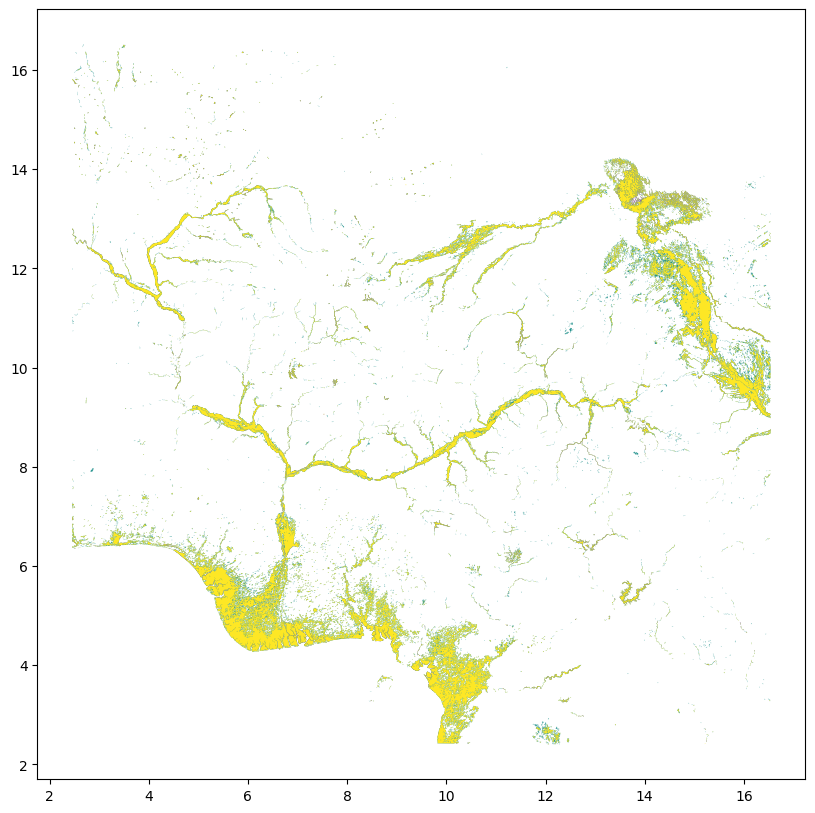

In [91]:
ax = gdf_combined.plot(figsize=(12, 10), cmap="viridis")